#Tugas Lab



1. Buatlah model SVM dengan menggunakan data voice.csv dengan ketentuan,

- a. Split data dengan rasio 70:30 dan 80:20 untuk setiap model yang akan dibangun.

- Gunakan model dengan kernel linier.

- Gunakan model dengan kernel polynomial.

- Gunakan model dengan kernel RBF.

- b. Tabulasikan performansi setiap split dan kernel berdasarkan metrik akurasi.

2. Gunakan data pada praktikum 5 untuk membuat model klasifikasi siang dan malam menggunakan SVM dengan kernel RBF menggunakan fitur histrogram. Gunakan rasio 80:20. Anda dapat bereksperimen dengan hyperparameter tunning dari kernel RBF. Catat performansi akurasinya!

#Download Data

In [ ]:
from IPython.display import clear_output
!pip install gdown
clear_output()
!gdown --id "1AZBQJXhWjXA5zR-7LbbXAsAd-YqcC8pG"

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1AZBQJXhWjXA5zR-7LbbXAsAd-YqcC8pG
To: /content/voice.csv
100% 1.07M/1.07M [00:00<00:00, 12.2MB/s]


#Import Library

In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#1. Model SVM data voice

In [ ]:
data = pd.read_csv('voice.csv')
data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [ ]:
data['label'] = data['label'].map({'male': 0, 'female': 1})

In [ ]:
X = data.drop(columns=['label'])
y = data['label']

#Define Model

In [ ]:
def evaluate_svm_model(X, y, test_size):
  result = []
  kernels = ['linear', 'poly', 'rbf']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

  for kernel in kernels:
    model = SVC(kernel=kernel)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    result.append({'Split': f'{int((1-test_size)*100)}:{int(test_size*100)}', 'Kernel': kernel, 'Akurasi': accuracy})
  return result

# Split data dengan rasio 70:30 dan 80:20

In [ ]:
result_70_30 = evaluate_svm_model(X, y, test_size=0.3)
result_80_20 = evaluate_svm_model(X, y, test_size=0.2)

In [ ]:
result_df = pd.DataFrame(result_70_30 + result_80_20)
print(result_df)

   Split  Kernel   Akurasi
0  70:30  linear  0.926393
1  70:30    poly  0.490011
2  70:30     rbf  0.662461
3  80:20  linear  0.941640
4  80:20    poly  0.482650
5  80:20     rbf  0.656151


#2. Gunakan data pada praktikum 5 untuk membuat model klasifikasi siang dan malam menggunakan SVM dengan kernel RBF menggunakan fitur histrogram.

In [2]:
# Image directories
train_dir = "/content/drive/MyDrive/Colab Notebooks/MLearning/week 11/images/training/"
test_dir = "/content/drive/MyDrive/Colab Notebooks/MLearning/week 11/images/test/"

In [3]:
# load dataset
def load_dataset(img_dir):
    p = Path(img_dir)
    dirs = p.glob('*')
    img_list = []
    for dir in dirs:
        label = str(dir).split('/')[-1]
        for file in dir.glob('*.jpg'):
            img = mpimg.imread(file)
            if img is not None:
                img_list.append((img, label))
    return img_list

In [4]:
# load dataset training dan testing
train_img = load_dataset(train_dir)
test_img = load_dataset(test_dir)

In [5]:
print(f"Total data training: {len(train_img)}")
print(f"Total data testing: {len(test_img)}")

Total data training: 240
Total data testing: 160


In [6]:
# pra-pengolahan data (Resize + Label Encoding)
def standarized_input(image):
    return cv.resize(image, (256, 256))

def label_encoder(label):
    return 1 if label == 'day' else 0

def preprocess(img_list):
    std_list = []
    for img, label in img_list:
        std_img = standarized_input(img)
        num_label = label_encoder(label)
        std_list.append((std_img, num_label))
    return std_list

Ukuran gambar: (256, 256, 3)
Label numerik: 1


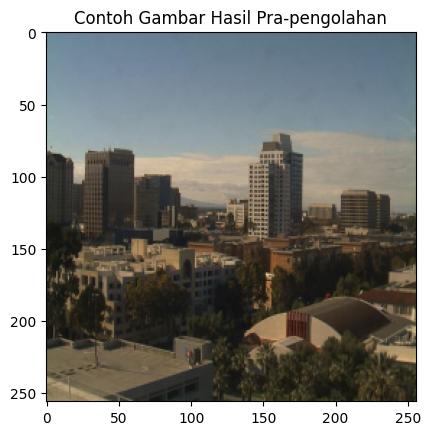

In [7]:
train_std = preprocess(train_img)
test_std = preprocess(test_img)

rand = np.random.randint(0, len(train_std))
print(f"Ukuran gambar: {train_std[rand][0].shape}")
print(f"Label numerik: {train_std[rand][1]}")
plt.imshow(train_std[rand][0])
plt.title("Contoh Gambar Hasil Pra-pengolahan")
plt.show()

In [8]:
# ekstraksi fitur histogram
def extract_histogram_features(img_list):
    features = []
    labels = []
    for img, label in img_list:
        # Flatten histogram dari 3 channel
        hist = cv.calcHist([img], [0, 1, 2], None, [32, 32, 32],
                            [0, 256, 0, 256, 0, 256])
        hist = cv.normalize(hist, hist).flatten()
        features.append(hist)
        labels.append(label)
    return np.array(features), np.array(labels)

In [9]:
X_train, y_train = extract_histogram_features(train_std)
X_test, y_test = extract_histogram_features(test_std)

print("Bentuk data training :", X_train.shape)
print("Bentuk data testing  :", X_test.shape)

Bentuk data training : (240, 32768)
Bentuk data testing  : (160, 32768)


In [10]:
# split data ulang (80:20)
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [11]:
# model SVM kernel RBF + Hyperparameter Tuning
param_grid = {
    'C': [0.1, 1, 10, 50],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, cv=3, verbose=1)
grid.fit(X_train_split, y_train_split)

print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best CV Accuracy: 1.0


In [12]:
# evaluasi model terbaik
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)

print(f"Akurasi pada data test: {acc_test:.4f}")

Akurasi pada data test: 0.9563


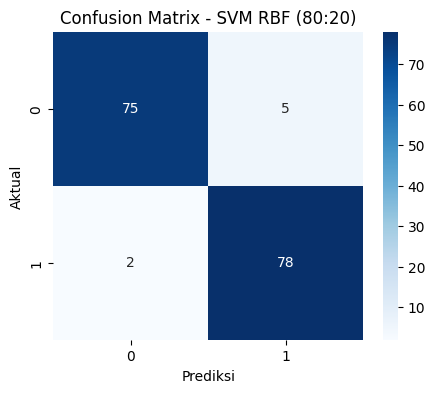


Classification Report:
              precision    recall  f1-score   support

       Night       0.97      0.94      0.96        80
         Day       0.94      0.97      0.96        80

    accuracy                           0.96       160
   macro avg       0.96      0.96      0.96       160
weighted avg       0.96      0.96      0.96       160



In [13]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix - SVM RBF (80:20)")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Night', 'Day']))